In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import warnings

from scipy import stats
from scipy.stats import zscore
from itertools import product

import seaborn as sns

In [2]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"
MILK_DATASET_PATH = f"{_BASE_URL}/milk.csv"

milk_data = pd.read_csv(MILK_DATASET_PATH, sep=";")
milk_data["log_mass"] = np.log(milk_data["mass"])
milk_data["neocortex.prop"] = milk_data["neocortex.perc"] / 100

In [3]:
milk_data[["kkals_z", "neocortex_prop_z", "log_mass_z"]] = milk_data[
    ["kcal.per.g", "neocortex.prop", "log_mass"]
].apply(zscore, nan_policy="omit")

In [4]:
milk_data_complete = milk_data.dropna()

In [5]:
# milk_data_ = milk_data_complete
milk_data_ = milk_data

In [6]:
with pm.Model() as model:
    sigma = pm.Exponential("sigma", 1)
    a = pm.Normal("a", 0, 0.5)
    bB = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    nu = pm.Normal("nu", 0, 0.5)
    sigma_B = pm.Exponential("sigma_B", 5)
    B = pm.Normal("B", nu, sigma_B, observed=milk_data_["neocortex_prop_z"])
    mu = pm.Deterministic("mu", a + bM * milk_data_["log_mass_z"] + bB * B)
    K = pm.Normal("K", mu, sigma, observed=milk_data_["kkals_z"].values)

/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in B contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [7]:
model

In [8]:
with model:
    trace = pm.sample(1000, tune=1000)
    # prior = pm.sample_prior_predictive(1000)
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["K"])
    # pm_data = az.from_pymc3(
    #    trace=trace, prior=prior, posterior_predictive=posterior_predictive
    # )
    pm_data = az.from_pymc3(trace=trace, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [B_missing, sigma_B, nu, bM, bA, a, sigma]
100%|██████████| 2000/2000 [00:08<00:00, 248.09it/s]


In [9]:
az.summary(pm_data.posterior["B_missing"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
B_missing[0],-0.517,0.896,-2.071,1.302,0.018,0.019,2468.0,1132.0,2481.0,1494.0,1.0
B_missing[1],-0.642,0.878,-2.250,0.989,0.017,0.015,2574.0,1818.0,2604.0,1766.0,1.0
B_missing[2],-0.633,0.926,-2.398,1.107,0.022,0.017,1815.0,1459.0,1863.0,1346.0,1.0
B_missing[3],-0.251,0.835,-1.680,1.424,0.016,0.019,2869.0,967.0,2896.0,1332.0,1.0
B_missing[4],0.432,0.847,-1.218,1.978,0.016,0.017,2703.0,1215.0,2720.0,1460.0,1.0
B_missing[5],-0.143,0.869,-1.828,1.501,0.015,0.021,3260.0,863.0,3241.0,1506.0,1.0
B_missing[6],0.180,0.833,-1.416,1.684,0.016,0.019,2615.0,1004.0,2607.0,1551.0,1.0
B_missing[7],0.233,0.841,-1.309,1.892,0.015,0.018,3090.0,1069.0,3090.0,1504.0,1.0
B_missing[8],0.484,0.848,-1.144,2.033,0.019,0.016,2060.0,1420.0,2074.0,1640.0,1.0
B_missing[9],-0.405,0.866,-2.020,1.221,0.017,0.018,2615.0,1116.0,2622.0,1177.0,1.0


```
B_impute[1] -0.56 0.91 -1.95 0.95 2602 1  
B_impute[2] -0.69 0.91 -2.10 0.79 2025 1  
B_impute[3] -0.68 0.94 -2.10 0.84 2086 1  
B_impute[4] -0.25 0.87 -1.61 1.15 3091 1  
B_impute[5] 0.48 0.85 -0.93 1.82 2532 1  
B_impute[6] -0.16 0.85 -1.50 1.16 2626 1  
B_impute[7] 0.19 0.85 -1.08 1.58 2640 1  
B_impute[8] 0.28 0.86 -1.06 1.62 3697 1  
B_impute[9] 0.52 0.87 -0.93 1.84 2574 1  
B_impute[10] -0.46 0.89 -1.87 0.93 2092 1  
B_impute[11] -0.27 0.86 -1.61 1.09 2650 1  
B_impute[12] 0.17 0.85 -1.21 1.49 2749
```

McElreath, Richard. Statistical Rethinking (Chapman & Hall/CRC Texts in Statistical Science) (p. 507). CRC Press. Kindle Edition. 

In [10]:
err = pm.hpd(pm_data.posterior["B_missing"].values)

/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (17). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (29). Passed array should have shape (chains, draws, *shape)
  UserWarning,


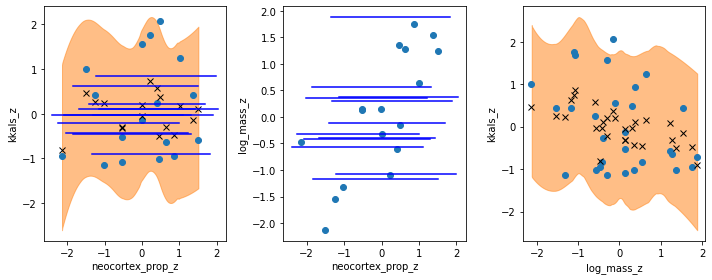

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
y_hat = pm_data.posterior_predictive["K"].values.reshape(-1, 29).mean(axis=0)
m = ~np.isnan(milk_data_["neocortex_prop_z"])
az.plot_hpd(
    milk_data_["neocortex_prop_z"][m], pm_data.posterior_predictive["K"].values[:, :, m]
)
plt.plot(milk_data_["neocortex_prop_z"], milk_data_["kkals_z"], "o")
plt.plot(milk_data_["neocortex_prop_z"], y_hat, "x", color="k")

plt.plot(err.T, np.vstack((y_hat[~m], y_hat[~m])), color="b")
plt.gca().set_xlabel("neocortex_prop_z")
plt.gca().set_ylabel("kkals_z")

plt.subplot(1, 3, 2)
m = ~np.isnan(milk_data_["neocortex_prop_z"])
plt.plot(milk_data_["neocortex_prop_z"], milk_data_["log_mass_z"], "o")
# plt.plot(milk_data_["neocortex_prop_z"], y_hat, "x", color="k")
plt.plot(
    err.T,
    np.vstack((milk_data_["log_mass_z"][~m], milk_data_["log_mass_z"][~m])),
    color="b",
)
plt.gca().set_xlabel("neocortex_prop_z")
plt.gca().set_ylabel("log_mass_z")

plt.subplot(1, 3, 3)
az.plot_hpd(milk_data_["log_mass_z"], pm_data.posterior_predictive["K"])
plt.plot(milk_data_["log_mass_z"], milk_data_["kkals_z"], "o")
plt.plot(milk_data_["log_mass_z"], y_hat, "x", color="k")
plt.gca().set_xlabel("log_mass_z")
plt.gca().set_ylabel("kkals_z")

plt.tight_layout()

In [12]:
# todo: figure out why this isn't working
# with model:
#    prior = pm.sample_prior_predictive(1000)

## Constrain B to be a proportion. 

In [13]:
# milk_data_ = milk_data_complete
milk_data_ = milk_data

In [14]:
# reparameterizations from https://mc-stan.org/docs/2_21/stan-users-guide/reparameterizations.html
# and BDA3 chapter 5.
with pm.Model() as model2:
    sigma = pm.Exponential("sigma", 1)
    a = pm.Normal("a", 0, 1)
    bB = pm.Normal("bA", 0, 1)
    bM = pm.Normal("bM", 0, 1)
    phi = pm.Beta("phi", 1, 1) # mean parameter, uniform prior
    lamb = pm.Pareto("lamb", 0.1, 1.5) # total count parameter
    alpha = lamb * phi 
    beta = lamb * (1 - phi) 
    B = pm.Beta("B", alpha=alpha, beta=beta, observed=milk_data_["neocortex.prop"])
    K_raw = pm.Normal("K_raw", 0, 1)
    mu = pm.Deterministic("mu", a + bM * milk_data_["log_mass_z"] + bB * B)
    K = pm.Normal("K", mu, sigma, observed=milk_data_["kkals_z"].values)

/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in B contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [15]:
with model2:
    trace = pm.sample(1000, tune=3000, init="adapt_diag")
    # prior = pm.sample_prior_predictive(1000)
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["K"])
    # pm_data = az.from_pymc3(
    #    trace=trace, prior=prior, posterior_predictive=posterior_predictive
    # )
    pm_data2 = az.from_pymc3(trace=trace, posterior_predictive=posterior_predictive)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [K_raw, B_missing, lamb, phi, bM, bA, a, sigma]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:42<00:00, 93.48it/s] 
The acceptance probability does not match the target. It is 0.8825707601432282, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:06<00:00, 324.06it/s]


/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (17). Passed array should have shape (chains, draws, *shape)
  UserWarning,
/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/data/base.py:146: UserWarning: More chains (2000) than draws (29). Passed array should have shape (chains, draws, *shape)
  UserWarning,


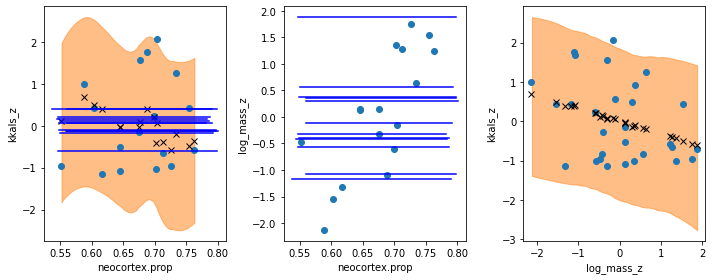

In [16]:
err = pm.hpd(pm_data2.posterior["B_missing"].values)
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
y_hat = pm_data2.posterior_predictive["K"].values.reshape(-1, 29).mean(axis=0)

m = ~np.isnan(milk_data_["neocortex.prop"])
az.plot_hpd(
    milk_data_["neocortex.prop"][m], pm_data2.posterior_predictive["K"].values[:, :, m]
)
plt.plot(milk_data_["neocortex.prop"], milk_data_["kkals_z"], "o")
plt.plot(milk_data_["neocortex.prop"], y_hat, "x", color="k")

plt.plot(err.T, np.vstack((y_hat[~m], y_hat[~m])), color="b")
plt.gca().set_xlabel("neocortex.prop")
plt.gca().set_ylabel("kkals_z")

plt.subplot(1, 3, 2)
m = ~np.isnan(milk_data_["neocortex.prop"])
plt.plot(milk_data_["neocortex.prop"], milk_data_["log_mass_z"], "o")
# plt.plot(milk_data_["neocortex_prop_z"], y_hat, "x", color="k")
plt.plot(
    err.T,
    np.vstack((milk_data_["log_mass_z"][~m], milk_data_["log_mass_z"][~m])),
    color="b",
)
plt.gca().set_xlabel("neocortex.prop")
plt.gca().set_ylabel("log_mass_z")

plt.subplot(1, 3, 3)
az.plot_hpd(milk_data_["log_mass_z"], pm_data2.posterior_predictive["K"])
plt.plot(milk_data_["log_mass_z"], milk_data_["kkals_z"], "o")
plt.plot(milk_data_["log_mass_z"], y_hat, "x", color="k")
plt.gca().set_xlabel("log_mass_z")
plt.gca().set_ylabel("kkals_z")

plt.tight_layout()